# **Adaptive RAG**

[Link to the paper](https://arxiv.org/abs/2403.14403)

**Architecture**:

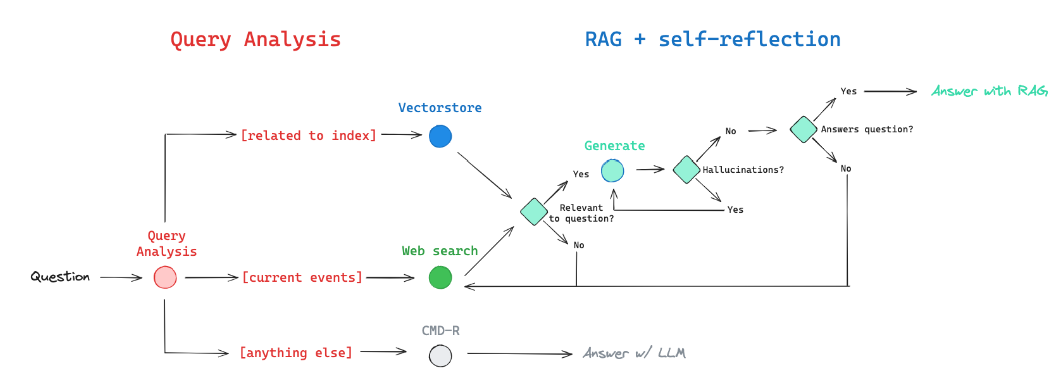

So the story now is that I have an application that I can interact with. My goal has been achieved by now, and the issues from naive RAG have been mostly solved, but I want a more powerful application.


The only knowledge my application has access to is the information in the PDFs I upload to its database. Maybe in some instance, there will be need for a piece of information that is related to the knowledge base but not in the PDF therefore my application has no access to it. Agentic RAG techniques are used to equip the generator llm with more abilities including access to foreign knowledge. 

Clearly you can begin to see the lack of flexibility. With chains, it's prebuilt functions, and you cannot really alter them to your taste. Adaptive RAG encourages an algorithmic building of your application so that a developer can have more flexibility in building. It is not very easy to get the llm to *behave* sometimes. By that I mean, I do not want certain unnecessary conversations while using the application. So how can I achieve this, prompt engineering? It is quite limited what you can do with prompt to get your llm to *behave* so this is the inflexibility I talk about.

So instead of if-the-user-input-is-this-then-always-go-to-our-database *hard-coded*, the flexibility comes in if-the-user-input-is-this-then-go-to-our-database-else-then-try-this-other-knowledgebase. It then becomes algorithmic, with conditional statements, and active states, etc. Therefore, chains will become less helpful. As such, Adaptive RAG techniques are built using knowledge graphs. Fortunately, langchain has a library called [**LangGraph**](https://python.langchain.com/v0.1/docs/langgraph/). 

I will be using LangGraph for this implementation. I will also use a free public API for searching the internet, as a tool for my chatbot. You can find out about [**Tavily Search API**](https://python.langchain.com/v0.1/docs/integrations/retrievers/tavily/).

This is not very perfect for my use case - it kind of defeats the purpose if I present my chatbot with external knowledge. However, I just want to keep going on and on about RAG. I love the technique. 




Anywho, I will modify my goal, to accomodate tools and function-calling, so that my chatbot could have realtime up-to-date conversations with the user like *what day of the week is it?* or *which club did Messi last score against?*. This is in addition to conversations around whatever document they upload to the application. Fun stuff!

Before I begin, I will load environment keys:

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

I will observe queries and responses using Langchain's observability tool: [**Langsmith**](https://docs.smith.langchain.com/old). Make sure your LANGCHAIN_API_KEY has been sent to the environment.

In [33]:
import os
from uuid import uuid4


unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
print("-"*40)
os.environ["LANGCHAIN_PROJECT"] = f"Blaq's PDF Chatbot - {unique_id}"

----------------------------------------


In [4]:
# Download PDF file
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


My pipeline:

Let me improve upon my embeddings. I visited this online leaderboard - [**MTEB- Leaderboard**](https://huggingface.co/spaces/mteb/leaderboard), and settled for [**avsolatorio/GIST-all-MiniLM-L6-v2**](https://huggingface.co/avsolatorio/GIST-all-MiniLM-L6-v2) over all-MiniLM-L6-v2.


*avsolatorio/GIST-all-MiniLM-L6-v2* places higher than *all-MiniLM-L6-v2* in the leaderboard, and it is slightly less heavy.

In [2]:
import os
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# Check if there is a FAISS index locally
index_path = "faiss_index"
if os.path.exists(index_path):
    # Load the existing FAISS index
    hf = SentenceTransformerEmbeddings(model_name="avsolatorio/GIST-all-MiniLM-L6-v2")
    vectorstore = FAISS.load_local(index_path, hf, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
else:
    # Load the document and create embeddings
    loader = PyMuPDFLoader(input(""))
    text_data = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=20,
        length_function=len,
        is_separator_regex=False
    )
    chunks = text_splitter.split_documents(text_data)
    hf = SentenceTransformerEmbeddings(model_name="avsolatorio/GIST-all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(chunks, hf)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
    # Save the FAISS index locally
    vectorstore.save_local(index_path)

c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want

# **Advanced RAG**

# Defining Components

Router:

Helps my application decide whether to use the existing knowledgebase or to query the internet to answer the user question.

In [3]:
### Router
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_cohere import ChatCohere

# Data model
class web_search(BaseModel):
    """
    The internet. Use web_search to query the internet for questions that are not related to human nutrition.
    """
    query: str = Field(description="The query to use when searching the internet.")

class vectorstore(BaseModel):
    """
    A vectorstore containing documents on human nutrition. Use the vectorstore for questions on this topic ONLY.
    """
    query: str = Field(description="The query to use when searching the vectorstore.")

# Preamble
preamble = """You are an expert at routing user questions to the appropriate data source. Based on the provided question, please classify it into one of the following categories:

vectorstore: Questions related to human nutrition. 
classified: Questions that do not require up-to-date information and are also not based on human nutrition, such as questions about the emotional state of the chatbot, personal inquiries, or intimate requests.
web_search: Questions that require up-to-date information and could be related to human nutrition.

Reply with a JSON object containing a single key 'datasource'. Only reply with each classification such as 'vectorstore','classified', or 'web_search'. Please no preamble or explanation.

"""

# LLM with tool use and preamble
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_router = llm.bind_tools(tools=[web_search, vectorstore], preamble=preamble)

# Prompt
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{question}"),
    ]
)


question_router = route_prompt | structured_llm_router
response = question_router.invoke({"question": "what are macronutrients?"}) #what are macronutrients?
print(response.response_metadata['tool_calls'])
response = question_router.invoke({"question": "How many dogs live within Surulere?"}) #What are the types of agent memory?
print(response.response_metadata['tool_calls'])
response = question_router.invoke({"question": "Hi, how are you?"}) #Hi how are you?
print('tool_calls' in response.response_metadata)

[{'id': '40faa248d5a040f3bddc941385059c45', 'function': {'name': 'vectorstore', 'arguments': '{"query": "macronutrients"}'}, 'type': 'function'}]
[{'id': '411e9f92872b487dbccacfbf1e8a83b6', 'function': {'name': 'web_search', 'arguments': '{"query": "dogs Surulere"}'}, 'type': 'function'}]
False


You see, **response.response_data** does not have an ID for a new 'tool_calls' (FALSE). This means it does not make use of a tool in answering the query *Hi, how are you?*

So the router works. It successfully classifies the user query into one of two tool options. And if I wanted to make that out of 3 options then I just use a logic where          

*tool call = FALSE*. 

Great! Now I will define the retrieved documents' Grader.

Relevancy Grader/Retrieval Grader:

A component to grade the relevance of the retrieved documents to the user query.

In [4]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# Prompt
preamble = """You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments, preamble=preamble)

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "What are macronutrients?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
response =  retrieval_grader.invoke({"question": question, "document": doc_txt})
print(response)

binary_score='yes'


*Yes*, the retrieved documents are relevant... at least my grader thinks so. 


I just graded the performance of my vector database as a retriever by checking the *relevancy* of the retrieved documents to any query. Just by doing this - by grading my database, I have almost completed the implementation of Corrective RAG or CRAG.  All there is left to it is a *conditional edge* which will have the logic to decide if my application should search another knowledgebase that may have knowledge relating to the query, or maybe re-write my query, etc; for poor grade, or just go ahead to generate the reply; for good grade. You will get to understand better when I am designing my graph.

Okay, next, the re-writer.

Query Re-writer:

To restructure the query for easy retrieval.

In [5]:
### Re-writer

from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
import logging


# Preamble
preamble = """You a question re-writer that converts an input question to a better version that is optimized 
     for vectorstore retrieval. Look at the initial and formulate an improved question.
     Please no preamble or extra sentences only the improved question will suffice."""

# LLM
llm = ChatCohere(model_name="command-r", temperature=0).bind(preamble=preamble)

# Prompt
rewrite_prompt = lambda x: ChatPromptTemplate.from_messages(
    [
        HumanMessage(
            f"Question: {x['question']} \nAnswer: ",
            additional_kwargs={"documents": x["documents"]},
        )
    ]
)

# hide warning log
logging.getLogger().setLevel(logging.ERROR)

# Chain
question_rewriter = rewrite_prompt | llm | StrOutputParser()

question = "What are macronutrients?"
docs = retriever.invoke(question)
# Run
generation = question_rewriter.invoke({"documents": docs, "question": question})
print(generation)

What are the three classes of macronutrients?


Generator:

For responding to the user query.

In [6]:
question = "What are macronutrients?"

In [7]:
### Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
import logging


# Preamble
preamble = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question."""

# LLM
llm = ChatCohere(model_name="command-r", temperature=0).bind(preamble=preamble)

# Prompt
prompt = lambda x: ChatPromptTemplate.from_messages(
    [
        HumanMessage(
            f"Question: {x['question']} \nAnswer: ",
            additional_kwargs={"documents": x["documents"]},
        )
    ]
)

# hide warning log
logging.getLogger().setLevel(logging.ERROR)

# Chain
rag_chain = prompt | llm | StrOutputParser()
docs = retriever.invoke(question)
# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

Macronutrients are nutrients that are needed in large amounts. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. Proteins provide structure to bones, muscles and skin, and play a role in conducting most of the chemical reactions that take place in the body.


Substitute LLM / Fallback:



A substitute generator using its pretrained knowledge to try to answer user query without ID for 'tool_calls'. This will be particularly useful for queries like: *Hi, how are you?* . This will be used to tackle the issue of a *guided* response.

In [9]:
### LLM fallback

from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage


# Preamble
preamble = """You are an assistant for question-answering tasks. Answer the following question only with this reply - I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about your documents. 
    Please no preamble or extra sentences just this same reply - I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about your documents"""

# LLM
llm = ChatCohere(model_name="command-r", temperature=0).bind(preamble=preamble)

# Prompt
prompt2 = lambda x: ChatPromptTemplate.from_messages(
    [
        HumanMessage(
            f"Question: {x['question']} \nAnswer: "
        )
    ]
)

# Chain
rag_chain2 = prompt2 | llm | StrOutputParser()

# Run
question = "Hi how are you?"
generation2 = rag_chain2.invoke({"question": question})
print(generation2)

I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about your documents.


Finally, I will test for hallucinations (if, or not, the responses are from the entire knowledge base my application has access to) and also for correctness (the usefulness of the response to the query) of the generation stage, using the next 2 components. This part of the Adaptive RAG architecture is the *Self RAG* implementation which checks for *llm hallucination*.

Hallucination Grader:

To test for llm hallucination.

In [10]:
question = "What are macronutrients?"

In [11]:
### Hallucination Grader

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# Preamble
preamble = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
Provide the binary score as a JSON with a single key 'score' and no preamble or explanation."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations, preamble=preamble)

# Prompt
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        # ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
docs = retriever.invoke(question)
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='no')

In [12]:
(hallucination_grader.invoke({"documents": docs, "generation": generation})).binary_score

'yes'

Response Grader:


Grade the relevance of the generator's response to the user query.

In [13]:
### Answer Grader

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# Preamble
preamble = """You are a grader assessing whether an answer addresses / resolves a question \n
Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
Provide the binary score as a JSON with a single key 'score' and no preamble or explanation."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer, preamble=preamble)

# Prompt
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question,"generation": generation})

All is fine and good. The components look set and ready, time to create a chart. But first, the tool.

### Web Search Tool

To gain access to this API as a tool, you need an API key. Get it [here](https://app.tavily.com/home).

In [47]:
! pip install -qU tavily-python

In [14]:
import getpass
import os

if "TAVILY_API_KEY" not in os.environ:
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Provide your Tavily Search Api Key here: ")
  print("TAVILY_API_KEY successfully sent to the environment")

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults()

Does this not feel like a video game match and what I am now doing is selecting/choosing my characters and defining/building their abilities?

Anyway, with my components already locked-and-ready-to-load, *retriever* for information in database, and *web_search_tool*; a web tool for external and more-recent knowledge, I will now create and compile the workflow in a graphical manner. Graphs are great for agentic RAGs; RAGS with tools. They are similar to chains but they link nodes together using edges instead of chains. Pay attention to the conditonal edge and the router. It is the router that completes Adaptive RAG implementation.


Okay, Let me now implement the graph.

### Graph
Capture the Adaptive RAG architecture as a control workflow using LangGraph.

I will define the state of the graph as a class.

In [16]:
# state dict

from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """|
    Represents the state of my graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question : str
    generation : str
    documents : List[str]

In [18]:
# defining the nodes and that conditional edge from earlier

import pprint
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("Retrieving...")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def llm_fallback(state):
    """
    Generate answer using the LLM w/o vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("Substitute LLM.")
    question = state["question"]
    generation2 = rag_chain2.invoke({"question": question})
    return {"question": question, "generation": generation2}

def generate(state):
    """
    Generate answer using the vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("Generating response...")
    question = state["question"]
    documents = state["documents"]
    if not isinstance(documents, list):
      documents = [documents]

    # RAG generation
    generation = rag_chain.invoke({"documents": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("Checking Document's relevance to query...")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score
        if grade == "yes":
            print("GRADE: Document relevant")
            filtered_docs.append(d)
        else:
            print("GRADE: Document NOT relevant.")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("Re-writing user query...")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("searching the internet...")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d.get("content", "") for d in docs if isinstance(d, dict)])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

### Edges ###

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("Routing query...")
    question = state["question"]
    source = question_router.invoke({"question": question})
    
    # Fallback to LLM or raise error if no decision
    if "tool_calls" not in source.additional_kwargs:
        print("Routing query to substitute generator...")
        return "llm_fallback" 
    if len(source.additional_kwargs["tool_calls"]) == 0:
      raise "Router could not decide source"

    # Choose datasource
    datasource = source.additional_kwargs["tool_calls"][0]["function"]["name"]
    if datasource == 'web_search':
        print("Routing query to the web search tool...")
        return "web_search"
    elif datasource == 'vectorstore':
        print("Routing query to vector database...")
        return "vectorstore"
    else: 
        print("Routing query to substitute LLM...") # when tool_calls = FALSE
        return "llm_fallback"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("Assessing Graded documents...")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # It will re-generate a new query
        print("DECISION: Retrieved documents are NOT relevant to query, restructuring query...")
        return "transform_query"
    else:
        # relevant documents, so generate answer
        print("DECISION: Respond.")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("Checking for hallucination...")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    #grade = score.binary_score

    # Check hallucination
    if score == "yes":
        print("DECISION: Response is grounded. No hallucination.")
        # Check question-answering
        print("Grading relevancy to user query...")
        score2 = answer_grader.invoke({"question": question,"generation": generation})
        #grade = score.binary_score
        if score2 == "yes":
            print("DECISION: Response is relevant to user query.")
            return "useful"
        else:
            print("DECISION: Response DOES NOT address user query.")
            return "not useful"
    else:
        pprint("DECISION: Hallucinating. Response is NOT grounded.")
        return "not supported"

Now compiling the flow chart.

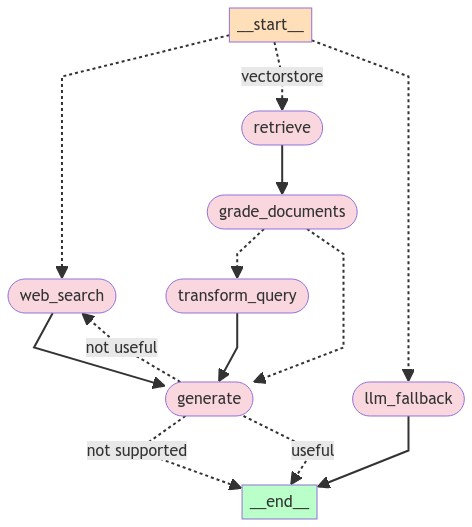

In [19]:
# The graph 

from langgraph.graph import END, StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # rag
workflow.add_node("llm_fallback", llm_fallback) # llm
workflow.add_node("transform_query", transform_query) #query restructure

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "llm_fallback": "llm_fallback",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": END, # Hallucinations: re-generate 
        "not useful": "web_search", # Fails to answer question: fall-back to web-search 
        "useful": END,
    },
)
workflow.add_edge("transform_query", "generate")
workflow.add_edge("llm_fallback", END)

# Compile
app = workflow.compile()
app.get_graph().draw_mermaid_png(output_file_path="graph.png")

# Display the image
display(Image(filename="graph.png"))

Great! Now, let me try it out.

In [212]:
from pprint import pprint

# Run 
inputs = {"question": "What is this document about?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

Routing query...
Routing query to substitute generator...
Substitute LLM.
"Node 'llm_fallback':"
'\n---\n'
"I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about your documents."


In [20]:
from pprint import pprint

# Run
inputs = {"question": "Where is Nigeria?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

Routing query...
Routing query to the web search tool...
searching the internet...
"Node 'web_search':"
'\n---\n'
Generating response...
Checking for hallucination...
'DECISION: Hallucinating. Response is NOT grounded.'
"Node 'generate':"
'\n---\n'
('Nigeria is bordered to the north by Niger, to the east by Chad and Cameroon, '
 'to the south by the Gulf of Guinea in the Atlantic Ocean, and to the west by '
 'Benin.')


In [21]:
# Run
inputs = {"question": "What are macronutrients?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

Routing query...
Routing query to vector database...
Retrieving...
"Node 'retrieve':"
'\n---\n'
Checking Document's relevance to query...
GRADE: Document relevant
GRADE: Document relevant
GRADE: Document relevant
GRADE: Document relevant
GRADE: Document relevant
GRADE: Document relevant
GRADE: Document relevant
Assessing Graded documents...
DECISION: Respond.
"Node 'grade_documents':"
'\n---\n'
Generating response...
Checking for hallucination...
'DECISION: Hallucinating. Response is NOT grounded.'
"Node 'generate':"
'\n---\n'
('Macronutrients are nutrients that are needed in large amounts. There are '
 'three classes of macronutrients: carbohydrates, lipids, and proteins. These '
 'can be metabolically processed into cellular energy. Proteins provide '
 'structure to bones, muscles and skin, and play a role in conducting most of '
 'the chemical reactions that take place in the body.')


In [23]:
# Run
from pprint import pprint
inputs = {"question": "Who are you?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value ["generation"])

Routing query...
Routing query to substitute generator...
Substitute LLM.
"Node 'llm_fallback':"
'\n---\n'
"I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about your documents."


In [24]:
# Run
from pprint import pprint
inputs = {"question": "When is Conor Mcgregor fighting next?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value ["generation"])

Routing query...
Routing query to the web search tool...
searching the internet...
"Node 'web_search':"
'\n---\n'
Generating response...
Checking for hallucination...
'DECISION: Hallucinating. Response is NOT grounded.'
"Node 'generate':"
'\n---\n'
('Conor McGregor will next fight on June 29, 2024, at UFC 303 in Las Vegas. He '
 'will fight Michael Chandler, capping off International Fight Week 2024.')


From the discussions above, it's clear that Cohere command models are excellent for Retrieval-Augmented Generation (RAG) designs, but they do require payment for API calls which is then a cause for worry when the developer is thinking about a production-scale project. However, it's important to note that the same implementation can be achieved using open-source models as well. You can find this implementation in *adaptive_rag_with_local_llm.ipynb*. While the results may not be as impressive as those obtained here with Cohere models, they will still be decent. From there, you can experiment with the prompt, try a paid embedding model, or even explore other vector stores to improve the results.

Moving on, and despite the success of the current implementation, I still feel that the control workflow is somewhat *not-smooth-'nuff-yet*. I've been intrigued by the idea of agents and the concept of a REACT agent (a reasoning bot), which thinks independently and functions similarly to how the router works in the current implementation, except that I do not need to define the routing logic myself. If I decide to use another file other than this one on Human Nutrition, I have to redefine the router logic. Not very automated, is it?


 Recently, I came across a paper that discusses a more advanced agent architecture called the Modular Reasoning and Knowledge Learning (MRKL) REACT agent, which I'm excited to try out. You can read more about it [**here**](https://arxiv.org/abs/2205.00445).

I look forward to implementing this agent architecture in the final notebook - *rag_with_agent_executor.ipynb*. 


See you there.